## Imports

In [1]:
import torch
import time
from nd_rotary_encodings import RoPEEncodingND
from torch import nn, Tensor
import torch.nn.functional as F
from torch.profiler import profile, ProfilerActivity, record_function, schedule, profiler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

device = "cuda" if torch.cuda.is_available() else "cpu"

## Import copy of rope-vit implementation

In [2]:
# import rope-for-vit.py
import os
import sys
from pathlib import Path

try:
    notebook_dir = Path(__file__).parent
except NameError:
    import os

    notebook_dir = Path(os.getcwd())

project_root = notebook_dir.parent
sys.path.append(str(project_root))

from thirdparty.rope_self_attn import RoPEAttention as RoPEAttention_Mixed
from thirdparty.rope_self_attn import Attention

## Define full attention operation with RoPE for complete comparison

In [3]:
class RoPEAttention_nd(Attention):
    """Full attention operation with RoPE for comparison with official RoPE-Mixed equivalent"""

    def __init__(
        self,
        *args,
        rope_theta=10.0,
        use_checkpointing=False,
        forward_only=False,
        inplace=False,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        self.pos_encoding = RoPEEncodingND(
            position_dim=2,
            embed_dim=self.dim,
            n_heads=self.num_heads,
            rope_base_theta=rope_theta,
            use_checkpointing=use_checkpointing,
            forward_only=forward_only,
            inplace=inplace,
        )

    def forward(self, x: Tensor, x_positions: Tensor):
        batch_size, seq_len, embed_dim = x.shape
        head_dim = embed_dim // self.num_heads
        q, k, v = self.qkv(x).chunk(3, dim=-1)

        q, k = self.pos_encoding(q, x_positions, k)

        q = q.reshape(batch_size, seq_len, self.num_heads, head_dim).permute(0, 2, 1, 3)
        k = k.reshape(batch_size, seq_len, self.num_heads, head_dim).permute(0, 2, 1, 3)
        v = v.reshape(batch_size, seq_len, self.num_heads, head_dim).permute(0, 2, 1, 3)

        x = F.scaled_dot_product_attention(q, k, v, dropout_p=self.attn_drop.p)

        x = x.transpose(1, 2).reshape(batch_size, seq_len, embed_dim)

        x = self.proj(x)
        x = self.proj_drop(x)
        return x

## Define basic no-RoPE Attention

In [4]:
class BasicAttention(nn.Module):
    """Full attention operation without RoPE"""

    def __init__(
        self,
        embed_dim: int, num_heads: int, dropout: float = 0.0, qkv_bias=False
    ):
        super().__init__()

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        
        self.qkv = nn.Linear(embed_dim, 3 * embed_dim, bias=qkv_bias)
        
        self.dropout_p = dropout
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(dropout)

    def forward(self, x: Tensor):
        batch_size, seq_len, embed_dim = x.shape
        head_dim = embed_dim // self.num_heads
        q, k, v = self.qkv(x).chunk(3, dim=-1)

        q = q.reshape(batch_size, seq_len, self.num_heads, head_dim).permute(0, 2, 1, 3)
        k = k.reshape(batch_size, seq_len, self.num_heads, head_dim).permute(0, 2, 1, 3)
        v = v.reshape(batch_size, seq_len, self.num_heads, head_dim).permute(0, 2, 1, 3)

        x = F.scaled_dot_product_attention(q, k, v, dropout_p=self.dropout_p)

        x = x.transpose(1, 2).reshape(batch_size, seq_len, embed_dim)

        x = self.proj(x)
        x = self.proj_drop(x)
        return x

## Define profiling functions

In [6]:
def profile_forward_pass(model: nn.Module, *inputs, n_warmup=3, n_runs=10, inplace=False):
    torch.cuda.synchronize()
    torch.cuda.empty_cache()
    torch.cuda.reset_max_memory_allocated()
    
    if inplace:
        x_copy = inputs[0].clone()

    start_memory = torch.cuda.max_memory_allocated()

    forward_memory_peaks = []
    forward_wall_times = []

    for x in inputs:
        if isinstance(x, Tensor):
            assert x.device.type == "cuda"

    with (
        profile(
            activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
            schedule=schedule(wait=2, warmup=n_warmup, active=n_runs),
            profile_memory=True,
        ) as prof,
        torch.no_grad(),
    ):
        for i in range(2 + n_warmup + n_runs):
            if inplace:
                inputs = (x_copy.clone(), *inputs[1:])
            with torch.autograd.profiler.record_function("forward"):
                start_time = time.time()
                _ = model(*inputs)
                torch.cuda.synchronize()
                end_time = time.time()
            peak_forward_mem = torch.cuda.max_memory_allocated()
            forward_memory_peaks.append(peak_forward_mem)
            if i >= 2 + n_warmup:
                forward_wall_times.append(end_time - start_time)
            torch.cuda.reset_max_memory_allocated()
            prof.step()

    memory_stats = {
        "start_memory": start_memory,
        "after_forward_memory": np.array(forward_memory_peaks),
    }
    time_stats = {"forward_wall_time": np.array(forward_wall_times)}

    return {"profiler": prof, "memory_stats": memory_stats, "time_stats": time_stats}


def profile_forward_backward_pass(model: nn.Module, *inputs, n_warmup=3, n_runs=10):
    torch.cuda.synchronize()
    torch.cuda.empty_cache()
    torch.cuda.reset_max_memory_allocated()

    start_memory = torch.cuda.max_memory_allocated()

    model.train()
    for x in inputs:
        if isinstance(x, Tensor):
            assert x.device.type == "cuda"
            x.requires_grad_(True)

    forward_memory_peaks = []
    backward_memory_peaks = []

    forward_wall_times = []
    backward_wall_times = []

    with profile(
        activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
        schedule=schedule(wait=2, warmup=n_warmup, active=n_runs),
        profile_memory=True,
    ) as prof:
        for i in range(2 + n_warmup + n_runs):
            with torch.autograd.profiler.record_function("forward"):
                start_time = time.time()
                out = model(*inputs)
                torch.cuda.synchronize()
                end_time = time.time()
            after_forward_mem = torch.cuda.max_memory_allocated()
            forward_memory_peaks.append(after_forward_mem)
            if i >= 2 + n_warmup:
                forward_wall_times.append(end_time - start_time)

            torch.cuda.reset_max_memory_allocated()

            loss = out.mean()
            with torch.autograd.profiler.record_function("backward"):
                start_time = time.time()
                loss.backward()
                torch.cuda.synchronize()
                end_time = time.time()
            after_backward_mem = torch.cuda.max_memory_allocated()
            backward_memory_peaks.append(after_backward_mem)
            if i >= 2 + n_warmup:
                backward_wall_times.append(end_time - start_time)

            prof.step()
            model.zero_grad()

            torch.cuda.reset_max_memory_allocated()

    memory_stats = {
        "start_memory": start_memory,
        "after_forward_memory": np.array(forward_memory_peaks),
        "after_backward_memory": np.array(backward_memory_peaks),
    }
    time_stats = {
        "forward_wall_time": np.array(forward_wall_times),
        "backward_wall_time": np.array(backward_wall_times),
    }

    return {"profiler": prof, "memory_stats": memory_stats, "time_stats": time_stats}


def average_memory_stats(memory_stats):
    out = {}
    out["Forward pass"] = np.mean(
        memory_stats["after_forward_memory"] - memory_stats["start_memory"]
    )
    if "after_backward_memory" in memory_stats:
        out["Backward pass"] = np.mean(
            memory_stats["after_backward_memory"] - memory_stats["start_memory"]
        )
    return out

def dummy_stats(training: bool):
    memory_stats = {"start_memory": np.nan, "after_forward_memory": np.nan}
    time_stats = {"forward_wall_time": np.nan}
    
    if training:
        memory_stats["after_backward_memory"] = np.nan
        time_stats["backward_wall_time"] = np.nan
    
    return {"profiler": None, "memory_stats": memory_stats, "time_stats": time_stats}


def average_walltime_stats(time_stats):
    out = {}
    out["Forward pass"] = np.mean(time_stats["forward_wall_time"])
    if "backward_wall_time" in time_stats:
        out["Backward pass"] = np.mean(time_stats["backward_wall_time"])
    return out


def average_stats(memory_stats, time_stats):
    return {
        "Memory": average_memory_stats(memory_stats),
        "Walltime": average_walltime_stats(time_stats),
    }

## Setup functions

In [7]:
def get_test_data(
    batch_size: int, embed_dim: int, height: int, width: int, device: str | torch.device
):
    x = torch.randn(batch_size, height, width, embed_dim, device=device)
    x_pos = RoPEEncodingND.position_grid(x.shape, device=device, dtype=x.dtype)

    # Put into expected shapes for each
    x_reference = (
        x.transpose(1, 2).flatten(1, 2).contiguous()
    )  # [batch, seq_len, embed_dim]
    x_nd = x.flatten(1, 2).contiguous()  # [batch, seq_len, embed_dim]
    x_pos = x_pos.view(1, -1, 2).contiguous()  # [1, seq_len, 2]

    # Add 0th-index embedding without a specified position as expected by RoPE-Mixed layer
    x_dummy = torch.randn(batch_size, 1, embed_dim, device=x.device, dtype=x.dtype)
    x_reference = torch.cat([x_dummy, x_reference], dim=1)
    x_nd = torch.cat([x_dummy, x_nd], dim=1)

    x_pos_dummy = x_pos.new_zeros(1, 1, 2)
    x_pos = torch.cat([x_pos_dummy, x_pos], dim=1)

    return {
        "x_nd": x_nd,
        "x_pos": x_pos,
        "x_reference": x_reference,
    }


def get_test_layers(embed_dim: int, n_heads: int):
    rope_attn_reference = RoPEAttention_Mixed(embed_dim, num_heads=n_heads)
    rope_attn_nd = RoPEAttention_nd(embed_dim, num_heads=n_heads)
    rope_attn_nd_checkpointed = RoPEAttention_nd(
        embed_dim, num_heads=n_heads, use_checkpointing=True
    )
    rope_attn_nd_forward_only = RoPEAttention_nd(
        embed_dim, num_heads=n_heads, forward_only=True, inplace=True
    )
    
    attn_no_rope = BasicAttention(embed_dim, num_heads=n_heads)

    with torch.no_grad():
        rope_attn_nd.load_state_dict(rope_attn_reference.state_dict(), strict=False)
        rope_attn_nd_checkpointed.load_state_dict(
            rope_attn_reference.state_dict(), strict=False
        )
        rope_attn_nd_forward_only.load_state_dict(
            rope_attn_reference.state_dict(), strict=False
        )
        attn_no_rope.load_state_dict(rope_attn_reference.state_dict(), strict=False)

    return (
        rope_attn_reference,
        rope_attn_nd,
        rope_attn_nd_checkpointed,
        rope_attn_nd_forward_only,
        attn_no_rope,
    )

## Define testing function

In [8]:
def run_test(
    height: int,
    width: int,
    batch_size: int,
    embed_dim: int,
    n_heads: int,
    device: str | torch.device,
):
    (
        rope_attn_reference,
        rope_attn_nd,
        rope_attn_nd_checkpointed,
        rope_attn_nd_forward_only,
        attn_no_rope,
    ) = get_test_layers(embed_dim, n_heads)
    test_data = get_test_data(batch_size, embed_dim, height, width, "cpu")

    if height * width <= 64 * 64:
        stats_ref_fwd = profile_forward_pass(
            rope_attn_reference.to(device), test_data["x_reference"].to(device)
        )
        stats_ref_fwdbwd = profile_forward_backward_pass(
            rope_attn_reference.to(device), test_data["x_reference"].to(device)
        )
    else:
        stats_ref_fwd = dummy_stats(False)
        stats_ref_fwdbwd = dummy_stats(True)

    stats_norope_fwd = profile_forward_pass(
        attn_no_rope.to(device), test_data["x_reference"].to(device)
    )
    stats_norope_fwdbwd = profile_forward_backward_pass(
        attn_no_rope.to(device), test_data["x_reference"].to(device)
    )

    stats_nd_fwd = profile_forward_pass(
        rope_attn_nd.to(device),
        test_data["x_nd"].to(device),
        test_data["x_pos"].to(device),
    )
    stats_nd_fwdbwd = profile_forward_backward_pass(
        rope_attn_nd.to(device),
        test_data["x_nd"].to(device),
        test_data["x_pos"].to(device),
    )

    stats_nd_fwd_opt = profile_forward_pass(
        rope_attn_nd_forward_only.to(device),
        test_data["x_nd"].to(device),
        test_data["x_pos"].to(device),
        inplace=True,
    )

    stats_nd_fwdbwd_opt = profile_forward_backward_pass(
        rope_attn_nd_checkpointed.to(device),
        test_data["x_nd"].to(device),
        test_data["x_pos"].to(device),
    )

    del rope_attn_nd, rope_attn_reference
    torch.cuda.empty_cache()

    # Raw metrics
    raw_results = {
        "size": f"{height}x{width}",
        "ref_fwd": stats_ref_fwd,
        "ref_fwdbwd": stats_ref_fwdbwd,
        "nd_fwd": stats_nd_fwd,
        "nd_fwdbwd": stats_nd_fwdbwd,
        "norope_fwd": stats_norope_fwd,
        "norope_fwdbwd": stats_norope_fwdbwd
    }
    averaged_results = {
        "size": f"{height}x{width}",
        "No RoPE (Inference)": average_stats(
            stats_norope_fwd["memory_stats"], stats_norope_fwd["time_stats"]
        ),
        "Reference (Inference)": average_stats(
            stats_ref_fwd["memory_stats"], stats_ref_fwd["time_stats"]
        ),
        "Ours (Inference)": average_stats(
            stats_nd_fwd["memory_stats"], stats_nd_fwd["time_stats"]
        ),
        "Ours (Inference, Optimized)": average_stats(
            stats_nd_fwd_opt["memory_stats"], stats_nd_fwd_opt["time_stats"]
        ),
        "No RoPE (Training)": average_stats(
            stats_norope_fwdbwd["memory_stats"], stats_norope_fwdbwd["time_stats"]
        ),
        "Reference (Training)": average_stats(
            stats_ref_fwdbwd["memory_stats"], stats_ref_fwdbwd["time_stats"]
        ),
        "Ours (Training)": average_stats(
            stats_nd_fwdbwd["memory_stats"], stats_nd_fwdbwd["time_stats"]
        ),
        "Ours (Training, Optimized)": average_stats(
            stats_nd_fwdbwd_opt["memory_stats"], stats_nd_fwdbwd_opt["time_stats"]
        ),
    }

    return raw_results, averaged_results

## Runner function

In [9]:
def run_all_tests(
    batch_size: int,
    embed_dim: int,
    n_heads: int,
    sizes: list[tuple[int, ...]],
    device: str | torch.device,
):
    raw_results = []
    averaged_results = []
    torch.cuda.empty_cache()
    for size in sizes:
        print(f"Testing size {size}...")
        raw, avg = run_test(size[0], size[1], batch_size, embed_dim, n_heads, device)
        raw_results.append(raw)
        averaged_results.append(avg)

    return raw_results, averaged_results

## Benchmark configurations

In [ ]:
batch_size = 4
embed_dim = 256
n_heads = 8

# Use different image sizes
sizes = [
    (16, 16),
    (32, 32),
    (48, 48),
    (64, 64),
    (96, 96),
    (128, 128),
    (192, 192),
    (256, 256),
    # (512, 512),
    # (1024, 1024),
]

In [11]:
torch.cuda.empty_cache()

In [ ]:
_, results = run_all_tests(batch_size, embed_dim, n_heads, sizes, device)

Testing size (16, 16)...


/global/homes/m/mwright/.conda/envs/me_121/lib/python3.11/site-packages/torch/cuda/memory.py:365: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
/global/u2/m/mwright/Code/nd-rotary-encodings/thirdparty/rope_self_attn.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/global/homes/m/mwright/.conda/envs/me_121/lib/python3.11/site-packages/torch/cuda/memory.py:365: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


Testing size (32, 32)...


/global/u2/m/mwright/Code/nd-rotary-encodings/thirdparty/rope_self_attn.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


Testing size (48, 48)...
Testing size (64, 64)...
Testing size (96, 96)...
Testing size (128, 128)...
Testing size (192, 192)...
Testing size (256, 256)...
Testing size (512, 512)...


## Copy-paste results

In [ ]:
results_copy = [{'size': '16x16',
  'No RoPE (Inference)': {'Memory': {'Forward pass': np.float64(8334813.866666666)},
   'Walltime': {'Forward pass': np.float64(0.00032806396484375)}},
  'Reference (Inference)': {'Memory': {'Forward pass': np.float64(35877137.06666667)},
   'Walltime': {'Forward pass': np.float64(0.001152944564819336)}},
  'Ours (Inference)': {'Memory': {'Forward pass': np.float64(10440157.866666667)},
   'Walltime': {'Forward pass': np.float64(0.000916290283203125)}},
  'Ours (Inference, Optimized)': {'Memory': {'Forward pass': np.float64(7294429.866666666)},
   'Walltime': {'Forward pass': np.float64(0.0009888648986816407)}},
  'No RoPE (Training)': {'Memory': {'Forward pass': np.float64(9354649.6),
    'Backward pass': np.float64(14785467.733333332)},
   'Walltime': {'Forward pass': np.float64(0.0003561973571777344),
    'Backward pass': np.float64(0.0008229970932006836)}},
  'Reference (Training)': {'Memory': {'Forward pass': np.float64(37388151.46666667),
    'Backward pass': np.float64(53102182.4)},
   'Walltime': {'Forward pass': np.float64(0.0014158964157104492),
    'Backward pass': np.float64(0.00348355770111084)}},
  'Ours (Training)': {'Memory': {'Forward pass': np.float64(12396885.333333334),
    'Backward pass': np.float64(17904640.0)},
   'Walltime': {'Forward pass': np.float64(0.001225757598876953),
    'Backward pass': np.float64(0.002335643768310547)}},
  'Ours (Training, Optimized)': {'Memory': {'Forward pass': np.float64(11870549.333333334),
    'Backward pass': np.float64(17378304.0)},
   'Walltime': {'Forward pass': np.float64(0.0012183904647827149),
    'Backward pass': np.float64(0.0024880409240722657)}}},
 {'size': '32x32',
  'No RoPE (Inference)': {'Memory': {'Forward pass': np.float64(26856106.666666668)},
   'Walltime': {'Forward pass': np.float64(0.0011881589889526367)}},
  'Reference (Inference)': {'Memory': {'Forward pass': np.float64(304219136.0)},
   'Walltime': {'Forward pass': np.float64(0.003554368019104004)}},
  'Ours (Inference)': {'Memory': {'Forward pass': np.float64(35252906.666666664)},
   'Walltime': {'Forward pass': np.float64(0.0013710260391235352)}},
  'Ours (Inference, Optimized)': {'Memory': {'Forward pass': np.float64(25959082.666666668)},
   'Walltime': {'Forward pass': np.float64(0.0013505935668945313)}},
  'No RoPE (Training)': {'Memory': {'Forward pass': np.float64(30910259.2),
    'Backward pass': np.float64(52053674.666666664)},
   'Walltime': {'Forward pass': np.float64(0.0007870674133300781),
    'Backward pass': np.float64(0.0022719621658325194)}},
  'Reference (Training)': {'Memory': {'Forward pass': np.float64(312333243.73333335),
    'Backward pass': np.float64(573387025.0666667)},
   'Walltime': {'Forward pass': np.float64(0.003738069534301758),
    'Backward pass': np.float64(0.005947232246398926)}},
  'Ours (Training)': {'Memory': {'Forward pass': np.float64(43494126.93333333),
    'Backward pass': np.float64(64637542.4)},
   'Walltime': {'Forward pass': np.float64(0.0015771865844726562),
    'Backward pass': np.float64(0.002488398551940918)}},
  'Ours (Training, Optimized)': {'Memory': {'Forward pass': np.float64(39316206.93333333),
    'Backward pass': np.float64(60459622.4)},
   'Walltime': {'Forward pass': np.float64(0.0015050172805786133),
    'Backward pass': np.float64(0.0025231122970581056)}}},
 {'size': '48x48',
  'No RoPE (Inference)': {'Memory': {'Forward pass': np.float64(58103125.333333336)},
   'Walltime': {'Forward pass': np.float64(0.0024376869201660155)}},
  'Reference (Inference)': {'Memory': {'Forward pass': np.float64(1439242444.8)},
   'Walltime': {'Forward pass': np.float64(0.00664365291595459)}},
  'Ours (Inference)': {'Memory': {'Forward pass': np.float64(76985685.33333333)},
   'Walltime': {'Forward pass': np.float64(0.0029382228851318358)}},
  'Ours (Inference, Optimized)': {'Memory': {'Forward pass': np.float64(58103125.333333336)},
   'Walltime': {'Forward pass': np.float64(0.002978944778442383)}},
  'No RoPE (Training)': {'Memory': {'Forward pass': np.float64(67214472.53333333),
    'Backward pass': np.float64(115095893.33333333)},
   'Walltime': {'Forward pass': np.float64(0.002431154251098633),
    'Backward pass': np.float64(0.0063866376876831055)}},
  'Reference (Training)': {'Memory': {'Forward pass': np.float64(1457497702.4),
    'Backward pass': np.float64(2799648085.3333335)},
   'Walltime': {'Forward pass': np.float64(0.006688070297241211),
    'Backward pass': np.float64(0.014719414710998534)}},
  'Ours (Training)': {'Memory': {'Forward pass': np.float64(92284313.6),
    'Backward pass': np.float64(140165734.4)},
   'Walltime': {'Forward pass': np.float64(0.003033947944641113),
    'Backward pass': np.float64(0.00663142204284668)}},
  'Ours (Training, Optimized)': {'Memory': {'Forward pass': np.float64(86115737.6),
    'Backward pass': np.float64(133997158.4)},
   'Walltime': {'Forward pass': np.float64(0.0029968500137329103),
    'Backward pass': np.float64(0.006570959091186523)}}},
 {'size': '64x64',
  'No RoPE (Inference)': {'Memory': {'Forward pass': np.float64(100617693.86666666)},
   'Walltime': {'Forward pass': np.float64(0.007401514053344727)}},
  'Reference (Inference)': {'Memory': {'Forward pass': np.float64(4436512221.866667)},
   'Walltime': {'Forward pass': np.float64(0.017215204238891602)}},
  'Ours (Inference)': {'Memory': {'Forward pass': np.float64(134180317.86666666)},
   'Walltime': {'Forward pass': np.float64(0.008156347274780273)}},
  'Ours (Inference, Optimized)': {'Memory': {'Forward pass': np.float64(100617693.86666666)},
   'Walltime': {'Forward pass': np.float64(0.007721042633056641)}},
  'No RoPE (Training)': {'Memory': {'Forward pass': np.float64(116809113.6),
    'Backward pass': np.float64(202123741.86666667)},
   'Walltime': {'Forward pass': np.float64(0.007030081748962402),
    'Backward pass': np.float64(0.017441844940185545)}},
  'Reference (Training)': {'Memory': {'Forward pass': np.float64(4468956569.6),
    'Backward pass': np.float64(8735946205.866667)},
   'Walltime': {'Forward pass': np.float64(0.016725707054138183),
    'Backward pass': np.float64(0.03974299430847168)}},
  'Ours (Training)': {'Memory': {'Forward pass': np.float64(158794478.93333334),
    'Backward pass': np.float64(244109107.2)},
   'Walltime': {'Forward pass': np.float64(0.007623410224914551),
    'Backward pass': np.float64(0.01774897575378418)}},
  'Ours (Training, Optimized)': {'Memory': {'Forward pass': np.float64(150403822.93333334),
    'Backward pass': np.float64(235718451.2)},
   'Walltime': {'Forward pass': np.float64(0.007535481452941894),
    'Backward pass': np.float64(0.01765575408935547)}}},
 {'size': '96x96',
  'No RoPE (Inference)': {'Memory': {'Forward pass': np.float64(225048712.53333333)},
   'Walltime': {'Forward pass': np.float64(0.03441853523254394)}},
  'Reference (Inference)': {'Memory': {'Forward pass': np.float64("nan")},
   'Walltime': {'Forward pass': np.float64("nan")}},
  'Ours (Inference)': {'Memory': {'Forward pass': np.float64(300554376.53333336)},
   'Walltime': {'Forward pass': np.float64(0.03499000072479248)}},
  'Ours (Inference, Optimized)': {'Memory': {'Forward pass': np.float64(225048712.53333333)},
   'Walltime': {'Forward pass': np.float64(0.03501837253570557)}},
  'No RoPE (Training)': {'Memory': {'Forward pass': np.float64(262370030.93333334),
    'Backward pass': np.float64(455549576.53333336)},
   'Walltime': {'Forward pass': np.float64(0.03227622509002685),
    'Backward pass': np.float64(0.08250596523284912)}},
  'Reference (Training)': {'Memory': {'Forward pass': np.float64("nan"),
    'Backward pass': np.float64("nan")},
   'Walltime': {'Forward pass': np.float64("nan"),
    'Backward pass': np.float64("nan")}},
  'Ours (Training)': {'Memory': {'Forward pass': np.float64(356822425.6),
    'Backward pass': np.float64(550001971.2)},
   'Walltime': {'Forward pass': np.float64(0.03303415775299072),
    'Backward pass': np.float64(0.08338561058044433)}},
  'Ours (Training, Optimized)': {'Memory': {'Forward pass': np.float64(337946009.6),
    'Backward pass': np.float64(531125555.2)},
   'Walltime': {'Forward pass': np.float64(0.03314893245697022),
    'Backward pass': np.float64(0.08379042148590088)}}},
 {'size': '128x128',
  'No RoPE (Inference)': {'Memory': {'Forward pass': np.float64(399252138.6666667)},
   'Walltime': {'Forward pass': np.float64(0.10711665153503418)}},
  'Reference (Inference)': {'Memory': {'Forward pass': np.float64("nan")},
   'Walltime': {'Forward pass': np.float64("nan")}},
  'Ours (Inference)': {'Memory': {'Forward pass': np.float64(533478058.6666667)},
   'Walltime': {'Forward pass': np.float64(0.10805304050445556)}},
  'Ours (Inference, Optimized)': {'Memory': {'Forward pass': np.float64(399252138.6666667)},
   'Walltime': {'Forward pass': np.float64(0.10822679996490478)}},
  'No RoPE (Training)': {'Memory': {'Forward pass': np.float64(463992627.2),
    'Backward pass': np.float64(805992106.6666666)},
   'Walltime': {'Forward pass': np.float64(0.10458807945251465),
    'Backward pass': np.float64(0.24987783432006835)}},
  'Reference (Training)': {'Memory': {'Forward pass': np.float64("nan"),
    'Backward pass': np.float64("nan")},
   'Walltime': {'Forward pass': np.float64("nan"),
    'Backward pass': np.float64("nan")}},
  'Ours (Training)': {'Memory': {'Forward pass': np.float64(631898862.9333333),
    'Backward pass': np.float64(973898342.4)},
   'Walltime': {'Forward pass': np.float64(0.10621988773345947),
    'Backward pass': np.float64(0.2518514394760132)}},
  'Ours (Training, Optimized)': {'Memory': {'Forward pass': np.float64(598342382.9333333),
    'Backward pass': np.float64(940341862.4)},
   'Walltime': {'Forward pass': np.float64(0.1063542127609253),
    'Backward pass': np.float64(0.25277256965637207)}}},
 {'size': '192x192',
  'No RoPE (Inference)': {'Memory': {'Forward pass': np.float64(896976213.3333334)},
   'Walltime': {'Forward pass': np.float64(0.5529083728790283)}},
  'Reference (Inference)': {'Memory': {'Forward pass': np.float64("nan")},
   'Walltime': {'Forward pass': np.float64("nan")}},
  'Ours (Inference)': {'Memory': {'Forward pass': np.float64(1198974293.3333333)},
   'Walltime': {'Forward pass': np.float64(0.5595969200134278)}},
  'Ours (Inference, Optimized)': {'Memory': {'Forward pass': np.float64(896976213.3333334)},
   'Walltime': {'Forward pass': np.float64(0.562600040435791)}},
  'No RoPE (Training)': {'Memory': {'Forward pass': np.float64(1042631816.5333333),
    'Backward pass': np.float64(1812439381.3333333)},
   'Walltime': {'Forward pass': np.float64(0.5564205169677734),
    'Backward pass': np.float64(1.2413018226623536)}},
  'Reference (Training)': {'Memory': {'Forward pass': np.float64("nan"),
    'Backward pass': np.float64("nan")},
   'Walltime': {'Forward pass': np.float64("nan"),
    'Backward pass': np.float64("nan")}},
  'Ours (Training)': {'Memory': {'Forward pass': np.float64(1420406169.6),
    'Backward pass': np.float64(2190213734.4)},
   'Walltime': {'Forward pass': np.float64(0.5625000953674316),
    'Backward pass': np.float64(1.2520001888275147)}},
  'Ours (Training, Optimized)': {'Memory': {'Forward pass': np.float64(1344906649.6),
    'Backward pass': np.float64(2114714214.4)},
   'Walltime': {'Forward pass': np.float64(0.5623845100402832),
    'Backward pass': np.float64(1.2576284646987914)}}},
 {'size': '256x256',
  'No RoPE (Inference)': {'Memory': {'Forward pass': np.float64(1593789917.8666666)},
   'Walltime': {'Forward pass': np.float64(1.8618854761123658)}},
  'Reference (Inference)': {'Memory': {'Forward pass': np.float64("nan")},
   'Walltime': {'Forward pass': np.float64("nan")}},
  'Ours (Inference)': {'Memory': {'Forward pass': np.float64(2130669021.8666666)},
   'Walltime': {'Forward pass': np.float64(1.8723559379577637)}},
  'Ours (Inference, Optimized)': {'Memory': {'Forward pass': np.float64(1593789917.8666666)},
   'Walltime': {'Forward pass': np.float64(1.8727524280548096)}},
  'No RoPE (Training)': {'Memory': {'Forward pass': np.float64(1853627801.6),
    'Backward pass': np.float64(3223414749.866667)},
   'Walltime': {'Forward pass': np.float64(1.8654207706451416),
    'Backward pass': np.float64(3.923681402206421)}},
  'Reference (Training)': {'Memory': {'Forward pass': np.float64("nan"),
    'Backward pass': np.float64("nan")},
   'Walltime': {'Forward pass': np.float64("nan"),
    'Backward pass': np.float64("nan")}},
  'Ours (Training)': {'Memory': {'Forward pass': np.float64(2525217518.9333334),
    'Backward pass': np.float64(3895004467.2)},
   'Walltime': {'Forward pass': np.float64(1.8733469724655152),
    'Backward pass': np.float64(3.916962814331055)}},
  'Ours (Training, Optimized)': {'Memory': {'Forward pass': np.float64(2390997742.9333334),
    'Backward pass': np.float64(3760784691.2)},
   'Walltime': {'Forward pass': np.float64(1.8732707262039185),
    'Backward pass': np.float64(3.928135895729065)}}}]

In [ ]:
def convert_to_df(results):
    rows = []
    for block in results:
        size = block['size']
        for key, sub in block.items():
            if key == 'size':
                continue
            m = re.match(r'^(.*?)\s*\((.*?)\)$', key)
            assert m is not None
            impl = m.group(1).strip()
            specs = [s.strip() for s in m.group(2).split(',')]
            mode = specs[0]
            optimized = 'Optimized' in specs[1:]

            # Memory
            for pass_type, val in sub['Memory'].items():
                rows.append(dict(size=size,
                                Implementation=impl,
                                Mode=mode,
                                optimized=optimized,
                                metric='Memory',
                                pass_type=pass_type,
                                value=float(val)))

            # Walltime
            for pass_type, val in sub['Walltime'].items():
                rows.append(dict(size=size,
                                Implementation=impl,
                                Mode=mode,
                                optimized=optimized,
                                metric='Walltime',
                                pass_type=pass_type,
                                value=float(val)))

    df = pd.DataFrame(rows)
    
    # Better numbers for plotting
    df["size_px"] = df["size"].str.extract(r"^(\d+)").astype(int)
    df["value_mib"] = np.where(
        df["metric"] == "Memory", df["value"] / (1024 ** 2), np.nan
    )
    
    return df

In [31]:
df = convert_to_df(results)

## Forward comparison

/tmp/ipykernel_291183/3877501752.py:9: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.lineplot(


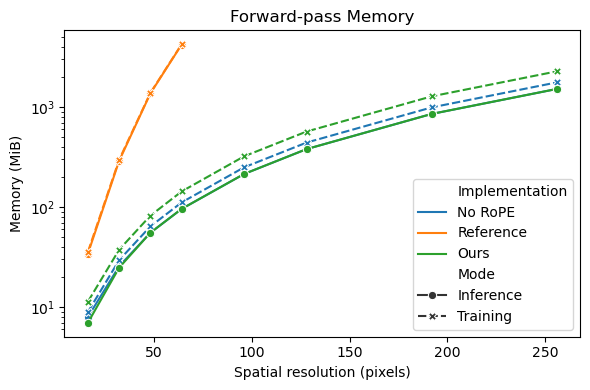

In [ ]:
mem_subset = df[
    (df["metric"] == "Memory")
    & (df["pass_type"] == "Forward pass")
    # & (df["Mode"] == "Inference")
    & ((df["Implementation"].isin(["Reference", "No RoPE"]) | df["optimized"]))
]

plt.figure(figsize=(6, 4))
sns.lineplot(
    data=mem_subset,
    x="size_px",
    y="value_mib",
    hue="Implementation",
    style="Mode",
    markers=True,
    dashes=True,
    palette=sns.color_palette("tab10"),
)
plt.title("Forward-pass Memory")
plt.xlabel("Spatial resolution (pixels)")  # first dimension of NxN
plt.ylabel("Memory (MiB)")
plt.semilogy()
plt.tight_layout()
plt.savefig("../images/memory_forward.png", dpi=200)
plt.show()

/tmp/ipykernel_291183/2914847694.py:9: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.lineplot(


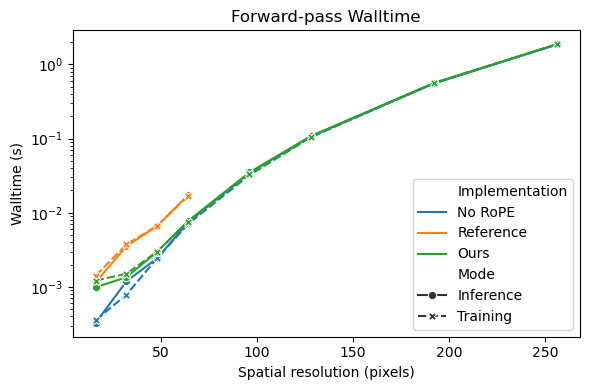

In [36]:
time_subset = df[
    (df["metric"] == "Walltime")
    & (df["pass_type"] == "Forward pass")
    # & (df["mode"] == "Inference")
    & ((df["Implementation"].isin(["Reference", "No RoPE"]) | df["optimized"]))
]

plt.figure(figsize=(6, 4))
sns.lineplot(
    data=time_subset,
    x="size_px",
    y="value",
    hue="Implementation",
    style="Mode",
    markers=True,
    dashes=True,
    palette=sns.color_palette("tab10"),
)
plt.title("Forward-pass Walltime")
plt.xlabel("Spatial resolution (pixels)")  # first dimension of NxN
plt.ylabel("Walltime (s)")
plt.semilogy()
plt.tight_layout()
plt.savefig("../images/walltime_forward.png", dpi=200)
plt.show()

## Backward comparison

/tmp/ipykernel_291183/3188706366.py:9: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.lineplot(


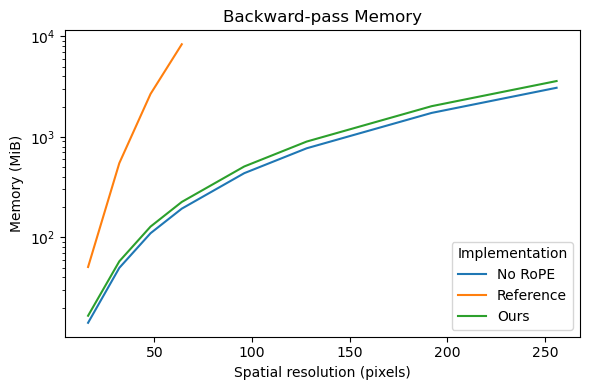

In [ ]:
mem_subset = df[
    (df["metric"] == "Memory")
    & (df["pass_type"] == "Backward pass")
    & (df["Mode"] == "Training")
    & ((df["Implementation"].isin(["Reference", "No RoPE"]) | df["optimized"]))
]

plt.figure(figsize=(6, 4))
sns.lineplot(
    data=mem_subset,
    x="size_px",
    y="value_mib",
    hue="Implementation",
    # style="Mode",
    markers=True,
    dashes=True,
    palette=sns.color_palette("tab10"),
)
plt.title("Backward-pass Memory")
plt.xlabel("Spatial resolution (pixels)")  # first dimension of NxN
plt.ylabel("Memory (MiB)")
plt.semilogy()
plt.tight_layout()
plt.savefig("../images/memory_backward.png", dpi=200)
plt.show()

/tmp/ipykernel_291183/3427945452.py:9: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.lineplot(


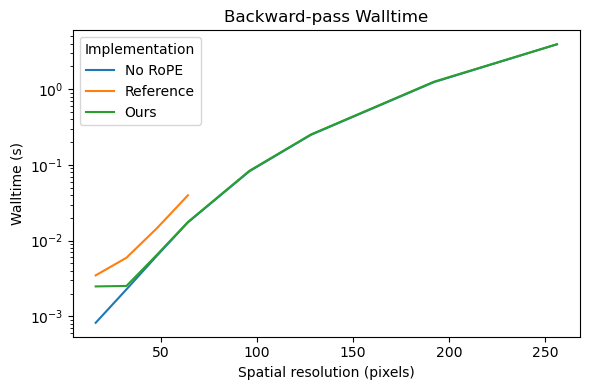

In [41]:
time_subset = df[
    (df["metric"] == "Walltime")
    & (df["pass_type"] == "Backward pass")
    & (df["Mode"] == "Training")
    & ((df["Implementation"].isin(["Reference", "No RoPE"]) | df["optimized"]))
]

plt.figure(figsize=(6, 4))
sns.lineplot(
    data=time_subset,
    x="size_px",
    y="value",
    hue="Implementation",
    # style="Mode",
    markers=True,
    dashes=True,
    palette=sns.color_palette("tab10"),
)
plt.title("Backward-pass Walltime")
plt.xlabel("Spatial resolution (pixels)")  # first dimension of NxN
plt.ylabel("Walltime (s)")
plt.semilogy()
plt.tight_layout()
plt.savefig("../images/walltime_backward.png", dpi=200)
plt.show()